# TDT4173 - Project report for Group 62 (long notebook)

**We did the Kaggle competition named Sales Forecasting and are named Group 62 as Kaggle Group name.**

The names and student IDs for those on Group 62 are:
1. **Ruben Mustad, 480858**
2. **Aneeq Ahsan, 546865**
3. **Axel Luiggi-Gørrissen, 554086**

Our notebook is divided into 4 parts
1. Load necessary packages and files
2. In the 2nd part, we try to create new features that can be useful for our model when trying to predict new sale values.
3. In the 3rd part, we do analysis on the data (EDA). That is, we make plots, look for patterns and inconsistencies and remove possible bad values.
4. In the 4th part we train our two models (LightGBM and XGBoost) using Optuna/Hyperopt. We also look into feature analysis/importance using RFE, RFECV and PDP.

NB:
1. We will refer to isPromo = 0 as Promo0, isPromo = 1 as Promo1 and isPromo = 2 as Promo2
2. Even though the dataset contains an energy drink, we will just call it all beer.

# 1. Load necessary packages and data files

Here we load the necessary packages to run our long notebook. 

In [40]:
import numpy as np
import pandas as pd
import warnings # 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
import sklearn.model_selection as model_selection
from optuna.samplers import TPESampler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
import hyperopt
import xgboost
# import shap 
from sklearn.feature_selection import RFE
from sklearn.inspection import PartialDependenceDisplay
from catboost import CatBoostRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import lightgbm as lgbm
from tqdm import trange
import workalendar

sns.set_style("whitegrid")
sns.set_palette("colorblind")
warnings.filterwarnings('ignore')

def rmse_loss(y_true, y_pred):
    log_error = y_pred - y_true
    return np.mean(log_error ** 2) ** 0.5

train = pd.read_csv('data/beer_train.csv',parse_dates=['Date'])
test = pd.read_csv('data/beer_test.csv',parse_dates=['Date'])
sku_features = pd.read_csv('data/sku_features.csv')
id_map = pd.read_csv('data/id_store_sku.csv')
submission = pd.read_csv('data/intro_submission.csv')

# 2. Creating features
In the second part, we want to create new features that may be helpful for our model.

Some features that could have been good, but we never implemented (either because of time, or would require more information):
- Stock prices for the beer companies (some news about the stock prices for Carlsberg going down in 2017, which made their sale worse)
- Sport events (football matches, wrestling, etc)
- Change in alcohol laws (seems to become stricter and stricter)
- Days until holidays
- Temperature/weather (good/bad)
- Tourism
- Total number of beer types (total, not only the one mentioned in SKU) sold by the store
- Number of beer sold by the store that was mentioned in the SKU
- How many promotion at the same time

## 2.1 Lag features

We tried different lag featues, such as 60, 90, 120, 150, 180, 365, 540 and 730. Smaller lag features would be useless, and lag features as high as 540 and 730 are also not very useful, as almost all of lag540 will be missing and all of lag730 will be missing in the training set. We did some testing, and found that 60, 90, 180 and 365 worked great for our model.

In [2]:
def create_lag(train, test):
    train['train'] = 1
    test['train'] = 0
    combined = pd.concat([train,test])
    lag = [60, 90, 180, 365]
    lag_cols = [f'lag_{lag}' for lag in lag]
    lag_colP = [f'lagPromo_{lag}' for lag in lag]
    lagPromo = [f'lag{lag}Promo' for lag in lag]

    for lags, lag_col in zip(lag,lag_cols):
        combined[lag_col] = combined[['ts_id', 'Sales']].groupby('ts_id')['Sales'].shift(lags)
    for lags, lag_colPs in zip(lag,lag_colP):
        combined[lag_colPs] = combined[['ts_id', 'isPromo']].groupby('ts_id')['isPromo'].shift(lags)

    train = combined[combined['train'] == 1]
    test = combined[combined['train'] == 0]

    train.drop(['train'], axis = 1, inplace = True)
    test.drop(['train'], axis = 1, inplace = True)

    def lag_creator(df): # create features with information about the lagged sale number and if it was promo or not
        df['lag60Promo'] = df['lag_60'].astype(str) + df['lagPromo_60'].astype(str)
        df['lag180Promo'] = df['lag_180'].astype(str) + df['lagPromo_180'].astype(str)
        df['lag90Promo'] = df['lag_90'].astype(str) + df['lagPromo_90'].astype(str)
        df['lag365Promo'] = df['lag_365'].astype(str) + df['lagPromo_365'].astype(str)
        return df

    train = lag_creator(train)
    test = lag_creator(test)

    # We remove the features about if promo or no promo for the different lag features (they got really low feature importance)
    remove = ['lagPromo_60', 'lagPromo_90', 'lagPromo_180', 'lagPromo_365']
    for i in remove:
        train.pop(i)
        test.pop(i)

    del(train['id'])
    del(test['Sales'])
    return train, test

train, test = create_lag(train, test)

## 2.2 Merge the given datasets

In [4]:
def merge(df, sku_features, id_map):
    df = pd.merge(df, id_map, how='left', on='ts_id')
    df = pd.merge(df, sku_features, how='left', on='SKU')
    return df
train = merge(train, sku_features, id_map)
test = merge(test, sku_features, id_map)

## 2.3 Time features

Here we add time features. These are quite essential for our model, as the will usually be a lot of pattern in the time (e.g., usually more sold on weekends and summer).

In [5]:
def time_features(df):
    df['day_of_month'] = df['Date'].dt.day
    df['day_of_week'] = df['Date'].dt.weekday
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['week'] = df['Date'].dt.week
    return df

train = time_features(train)
test = time_features(test)

## 2.4 Promo features

Below we add promo to our features. We also added a feature where we look at how long time there is between each promo.

In [6]:
def promo_features(df):
    df['ts_promo'] = df['ts_id'].astype(str) + df['isPromo'].astype(str)
    df['store_promo'] = df['Store'].astype(str) + df['isPromo'].astype(str)
    df['segment_promo'] = df['Segment'].astype(str) + df['isPromo'].astype(str)
    df['brand_promo'] = df['Brand'].astype(str) + df['isPromo'].astype(str)
    df['sku_promo'] = df['SKU'].astype(str) + df['isPromo'].astype(str)
    df['dom_promo'] = df['day_of_month'].astype(str) + df['isPromo'].astype(str)
    df['dow_promo'] = df['day_of_week'].astype(str) + df['isPromo'].astype(str)
    return df
train = promo_features(train)
test = promo_features(test)

def promo_relation(df):
    def days_to_promo(df):
        df["t"] = (df["Date"].where(df["isPromo"] > 0.0).bfill() - df["Date"]).dt.days
        return df

    def days_since_promo(df):
        df["t"] =  (df["Date"] - df["Date"].where(df["isPromo"] > 0.0).ffill()).dt.days
        return df
    df["days_to_promo"] = df.groupby([df.ts_id])[["Date", "isPromo", "SKU", "Store"]].apply(days_to_promo)["t"]
    df["days_since_promo"] = df.groupby([df.ts_id])[["Date", "isPromo", "SKU", "Store"]].apply(days_since_promo)["t"]
    
    return df

## 2.5 Special days

Here we add special days, such as summer, christmas, school holidays and party time (friday and saturday). We also tried adding all the national holidays, but it didn't give us a worse result. We believe this is due there being no national holidays in the test set and they overlap with the school holidays.

In [7]:
def interesting_days(df):
    # Since most of people in Russia are Orthodoxian, they do not celebrate christmas before start of january, but some study in 2015 
    # shows that Russia is starting to follow a more western trend when it comes to shopping (e.g., they shop a lot in mid-late december)
    # Therefore we chooses week 51-53. 
    df['special_days'] = df['week'].between(51, 53).astype(int) # christmas
    # The summer period (as we understood it) is also longer, but based on weather and when people usually have their vacation and stuff
    # we narrowed it down to week 26-31
    df['special_days'] += df['week'].between(26, 31).astype(int) # summer
    df['special_days'] += (df['week'] == 44).astype(int)
    df['special_daysPromo'] = df['special_days'].astype(str) + df['isPromo'].astype(str)

    # There seems to be more sale on friday and saturday, so they might bring some insight.
    df['party_time'] = df['day_of_week'].between(4,5).astype(int)
    df['party_timePromo'] = df['party_time'].astype(str) + df['isPromo'].astype(str)
    
    # School holidays in Russia 
    df['School_holiday'] = df['Date'].between('2015-01-01', '2015-01-15').astype(int)
    df['School_holiday'] += df['Date'].between('2015-03-23', '2015-03-27').astype(int)
    df['School_holiday'] += df['Date'].between('2015-05-26', '2015-08-31').astype(int)
    df['School_holiday'] += df['Date'].between('2015-11-02', '2015-11-06').astype(int)
    df['School_holiday'] += df['Date'].between('2016-01-01', '2016-01-15').astype(int)
    df['School_holiday'] += df['Date'].between('2016-03-21', '2016-03-25').astype(int)
    df['School_holiday'] += df['Date'].between('2016-05-30', '2016-08-31').astype(int)
    df['School_holiday'] += df['Date'].between('2016-11-07', '2016-11-11').astype(int)
    df['School_holiday'] += df['Date'].between('2017-01-02', '2017-01-15').astype(int)
    df['School_holiday'] += df['Date'].between('2017-03-22', '2017-03-29').astype(int)
    df['School_holiday'] += df['Date'].between('2017-06-01', '2017-09-01').astype(int)
    df['School_holiday'] += df['Date'].between('2017-11-05', '2017-11-12').astype(int)
    df['School_holidayPromo'] = df['School_holiday'].astype(str) + df['isPromo'].astype(str)
    return df

## 2.6 Other features
We also looked at other features, but they didn't seem to help our model. A similar explaination can be used here as above, they either didn't provide the model with any useful information or they overlapped.

In [8]:
import meteostat
from workalendar.europe import Russia
cal = Russia()

russia_holidays2015 = cal.holidays(2015)
russia_holidays2016 = cal.holidays(2016)
russia_holidays2017 = cal.holidays(2017)

def tried_features(df, sku_features, id_map, extra_features = False):
    # Here we add holidays + the first day of school (seems to be almost no sale on that day)
    df['holidays'] = (df['Date'] == '2015-09-01').astype(int)
    df['holidays'] += (df['Date'] == '2016-09-01').astype(int)
    df['holidays'] += (df['Date'] == '2017-09-01').astype(int)
    for i in range(len(russia_holidays2015)):
        df['holidays'] += (df['Date'] == str(russia_holidays2015[i][0])).astype(int)
        df['holidays'] += (df['Date'] == str(russia_holidays2016[i][0])).astype(int)
        if i < 15:
            df['holidays'] += (df['Date'] == str(russia_holidays2017[i][0])).astype(int)
    
    # Normal days
    df['work_time'] = df['day_of_week'].between(0,3).astype(int)
    df['work_timePromo'] = df['work_time'].astype(str) + df['isPromo'].astype(str)

    # Promo on product
    df['Product'] = df['day_of_week'].astype(str) + df['isPromo'].astype(str)
    
    df['quarter'] = df["Date"].dt.quarter
    # Weather
    stations = meteostat.Stations()
    stations = stations.region('RU', 'KDA')
    df_date_range = (df["Date"].min(), df["Date"].max())
    sochi = meteostat.Point(43.5992, 39.7257, 14)
    data = meteostat.Daily(sochi, df_date_range[0].to_pydatetime(), df_date_range[1].to_pydatetime())
    data = data.fetch()
    df = pd.merge(df, data["tavg"], how='left', left_on='Date', right_index=True)
    df["tavg_promo"] = df['tavg'].astype(str) + df['isPromo'].astype(str)
    return df

# 3. EDA
In the third part, we are concerned with analyzing our data to understand it, look for abnormalities and if we need to do some changes.

The data is a collection of 256 stores with their sale numbers, if they had promo, and the different types of beer they sold (with some specific about volume, segment etc.). 

We are not quite sure what the unit of the sale is. One possibility might be that it is measured in per 10000 rubles, so 0.1 would correspond to 1000 rubles (or 120 kr). This doesn't seem very much, however, since the maximum sale numer is 30.2 and 0.5 liter of beer seems to be in the price range 45-100 rubles, this might be reasonable. 

## 3.1 Visualization of sale and promo for each year

We start by visualizing the sum of sale each day and sum of promo each day for each year to get some understanding of the data.

A few remarks:
- Given that we only have 730 days (over 3 different years), it is hard to make any judgement on seasonal trends. 
- Almost no sale on the date 01.09.2015/2016 (the day of school start in Russia)
- A spike near the end of the year, which drops hard in the beginning of the new year
- Not so much variation in 2016 (at least in the first half) except for a few spikes here and there, compared to the other years
- For 2015 and 2016 it is hard to catch a trend between sales number and promos, however, in 2017 we see a much more "X goes up/down, Y goes up/down" relationship between promo and sales.

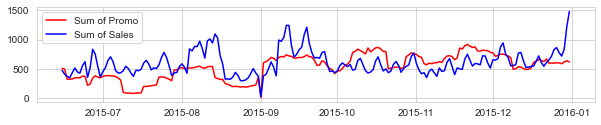

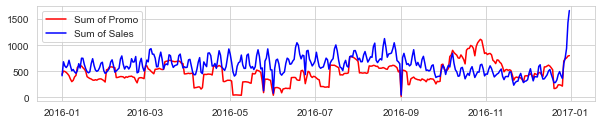

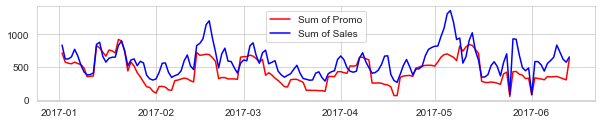

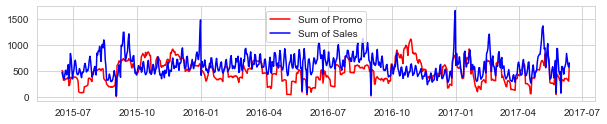

In [9]:
def plot_promoSale(a, k, j, title = None):
    x1 = np.unique(train['Date'])[a:k]
    sum_isPromo1 = []
    sum_isSale1 = []
    for i in x1:
        sum_isPromo1.append(np.sum(train[train['Date'] == i]['isPromo']))
        sum_isSale1.append(np.sum(train[train['Date'] == i]['Sales']))
    plt.figure(figsize = (10,8))
    plt.subplot(4, 1, j)
    plt.plot(x1, sum_isPromo1, color = 'red', label = 'Sum of Promo')
    plt.plot(x1, sum_isSale1, color = 'blue', label = 'Sum of Sales')
    plt.legend()
    plt.title(title)
plot_promoSale(0, 200, 1)
plot_promoSale(200, 566, 2)
plot_promoSale(567, -1, 3)
plot_promoSale(0, -1, 4)
plt.show()

## 3.2 Distribution of Promo

We see that there are 1035573 ($\sim$74.92%) values with Promo0, 343223 ($\sim$24.82%) values with Promo1 and 3525 ($\sim$0.26%) with Promo2 in the training set. In the test set, we find that 137963 ($\sim$71.52%) values are Promo0, 54771 values with Promo1 ($\sim$28.4%) and 148 values with Promo2 ($\sim$0.07%).

Thus the test set contains more of Promo1, but less of Promo0 and Promo2.

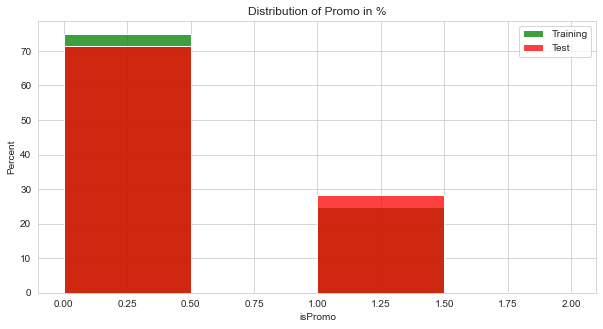

In [10]:
plt.figure(figsize = (10,5))
plt.title('Distribution of Promo in %')
sns.histplot(train['isPromo'], label = 'Training', stat = 'percent', color = 'green', binwidth = 0.5)
sns.histplot(test['isPromo'], label = 'Test', stat = 'percent', color = 'red', binwidth = 0.5)
plt.legend()
plt.show()

## 3.3 Brand and SKU
If we look at the generated train and test datasets now, we observe that the SKU and brand of the first product doesn't quite match. The SKU says Baltika №0, while the Brand says Baltika №3. We also notice that the distribution of the different brand varies a lot.

                            SKU       Brand
0          _Baltika №0 Can 0,45  Baltika №3
1          _Baltika №3 Can 0,45  Baltika №3
2          _Baltika №7 Can 0,45  Baltika №7
3       _Baltika №7 Bottle 0,47  Baltika №7
4          _Baltika №9 Can 0,45  Baltika №9
...                         ...         ...
192877      _Carlsberg Can 0,45   Carlsberg
192878     _Baltika №0 Can 0,45  Baltika №3
192879     _Baltika №3 Can 0,45  Baltika №3
192880     _Baltika №7 Can 0,45  Baltika №7
192881     _Baltika №9 Can 0,45  Baltika №9

[192882 rows x 2 columns]


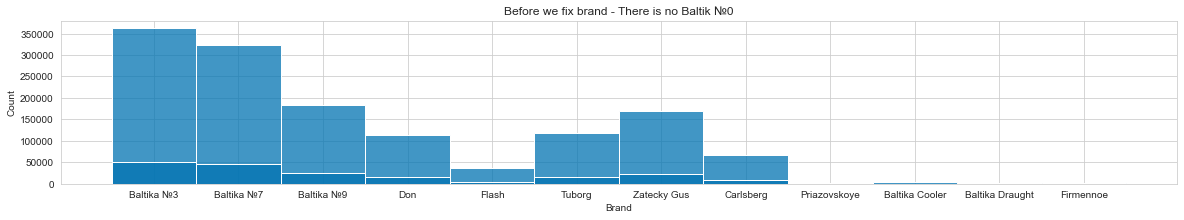

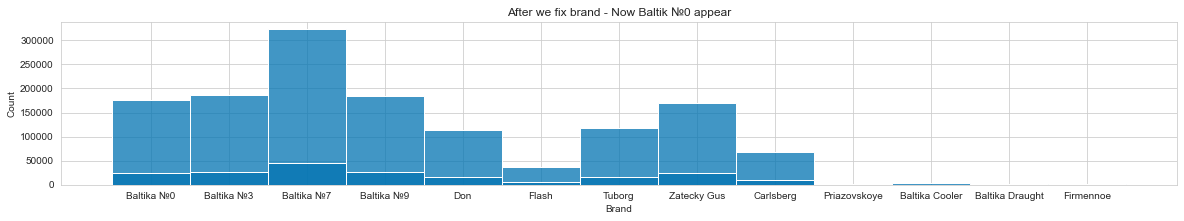

In [11]:
print(test[['SKU','Brand']])
plt.figure(figsize = (20,3))
plt.title('Before we fix brand - There is no Baltik №0')
sns.histplot(train['Brand'])
sns.histplot(test['Brand'])
plt.show()
def brand_fixer(df):
    SKU_baltik0 = df['SKU'] == '_Baltika №0 Can 0,45'
    Brand_baltik0 = df['Brand'] == 'Baltika №3'
    SKU_index = SKU_baltik0[SKU_baltik0].index
    Brand_index = Brand_baltik0[Brand_baltik0].index
    
    baltik0 = list(set(SKU_index).intersection(Brand_index))
    df['Brand'][baltik0] = 'Baltika №0'
    return df
train = brand_fixer(train)
test = brand_fixer(test)
plt.figure(figsize = (20,3))
plt.title('After we fix brand - Now Baltik №0 appear')
sns.histplot(train['Brand'])
sns.histplot(test['Brand'])
plt.show()

## 3.4 Sale numbers and promotion vs. week day

As expected, there is more beer sold on the weekend, while the week days are pretty similar. The promotion values doesn't seem to vary that much, but it is on its lowest on monday, and highest on friday and saturday.

We also searched online for rules regarding laws of selling beer in Russia. From the looks of it, it can be sold everyday and the time range is the same every day.

In [12]:
day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i in range(len(day)):
    print('Sales on', day[i], np.mean(train[train['day_of_week'] == i]['Sales']))
    print('Promotion on', day[i], np.mean(train[train['day_of_week'] == i]['isPromo']))
    print('')

Sales on Monday 0.2757213014024776
Promotion on Monday 0.24109188889728286

Sales on Tuesday 0.2881809725263484
Promotion on Tuesday 0.25120495580569613

Sales on Wednesday 0.29048317594605466
Promotion on Wednesday 0.24934652866963813

Sales on Thursday 0.29408441300883953
Promotion on Thursday 0.249913558149941

Sales on Friday 0.3683782034331354
Promotion on Friday 0.2651883415368344

Sales on Saturday 0.40230823638274704
Promotion on Saturday 0.26410527600374245

Sales on Sunday 0.3321649768131
Promotion on Sunday 0.25309156734328603



## 3.5 SKU and Promo
We see that Baltika 0, 3, 7 and 9 are being sold by most or all stores. We see that it goes slowly down after Baltika 7,  until it reaches Tuborg Green on Can, after that, almost no stores selling the rest.

We see that there are only 3 different SKU's that have Promo 2 in the training set and 4 in the test set.

We see that promos for the different SKUs isn't evenly distributed. We see that Baltik N0 has almost the same number of Promo1 in train and test, while the training set has 10 times as many values that are Promo0 than the test set. We also observe that Priazovskoye Bottle has no promotions in the test set. 

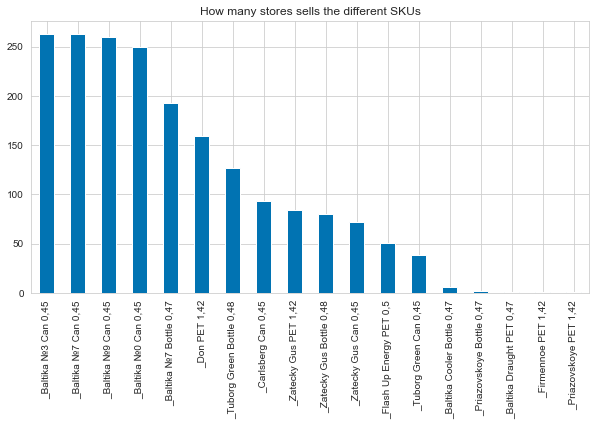

Type of SKU: _Baltika Cooler Bottle 0,47
Promo 0 for train: 3917 and Promo 0 for test: 574
Promo 1 for train: 469 and Promo 1 for test: 38
Promo 2 for train: 0 and Promo 2 for test: 0

Type of SKU: _Baltika Draught PET 0,47
Promo 0 for train: 580 and Promo 0 for test: 83
Promo 1 for train: 151 and Promo 1 for test: 19
Promo 2 for train: 0 and Promo 2 for test: 0

Type of SKU: _Baltika №0 Can 0,45
Promo 0 for train: 167835 and Promo 0 for test: 17872
Promo 1 for train: 7605 and Promo 1 for test: 6599
Promo 2 for train: 0 and Promo 2 for test: 9

Type of SKU: _Baltika №3 Can 0,45
Promo 0 for train: 142063 and Promo 0 for test: 15032
Promo 1 for train: 44342 and Promo 1 for test: 10962
Promo 2 for train: 0 and Promo 2 for test: 16

Type of SKU: _Baltika №7 Bottle 0,47
Promo 0 for train: 77797 and Promo 0 for test: 12585
Promo 1 for train: 57585 and Promo 1 for test: 6387
Promo 2 for train: 584 and Promo 2 for test: 0

Type of SKU: _Baltika №7 Can 0,45
Promo 0 for train: 105948 and Promo 0

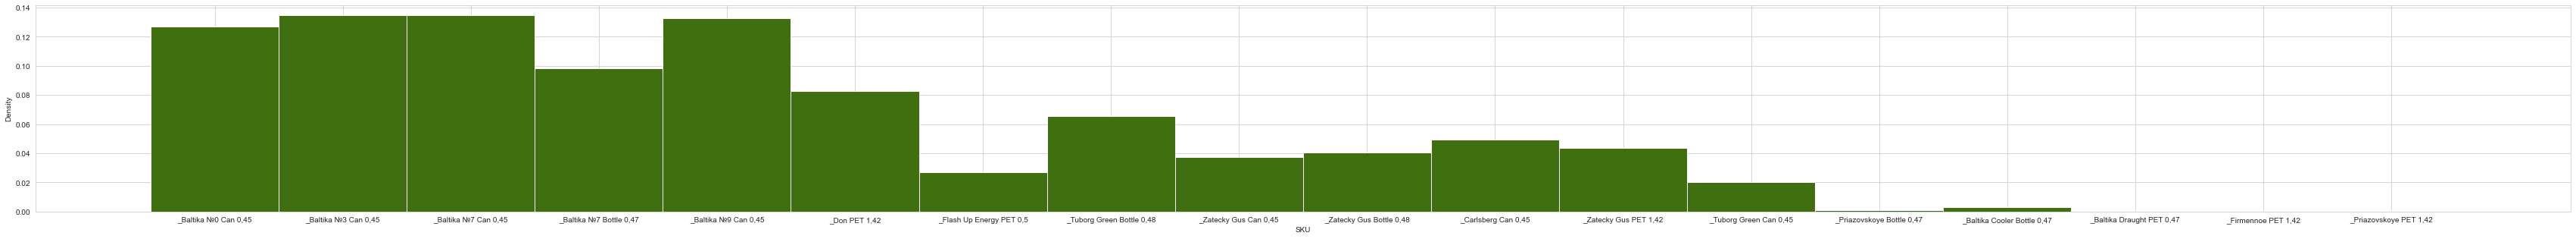

In [13]:
def X_and_promo(what):
    pack_unique = np.unique(train[what])
    for i in pack_unique: # only print out a certain amount to avoid many values
        print(f'Type of {what}:', i)
        print('Promo 0 for train: ' + str(len(train[((train['isPromo'] == 0) & (train[what] == i))])) + 
              ' and Promo 0 for test: '+ str(len(test[((test['isPromo'] == 0) & (test[what] == i))])))
        print('Promo 1 for train: ' + str(len(train[((train['isPromo'] == 1) & (train[what] == i))])) + 
              ' and Promo 1 for test: '+ str(len(test[((test['isPromo'] == 1) & (test[what] == i))])))
        print('Promo 2 for train: ' + str(len(train[((train['isPromo'] == 2) & (train[what] == i))])) + 
              ' and Promo 2 for test: '+ str(len(test[((test['isPromo'] == 2) & (test[what] == i))])))
        print('')
    if what == 'SKU':
        plt.figure(figsize = (60,5))
    sns.histplot(train[what], stat = 'density', color = 'red')
    sns.histplot(test[what], stat = 'density', color = 'green')
    plt.show()

plt.figure(figsize = (10,5))
plt.title('How many stores sells the different SKUs')
t = id_map['SKU'].value_counts()
plt.xlim([0, 256])
t.plot(kind='bar')
plt.show()
    
X_and_promo('SKU')

## 3.6 Pack and Promo

We see some interesting patterns in here. We observe that there isn't very often Promo1 on can (19%), but it occurs more often in the test set (29%). Bottles are very often on Promo1 (60%) in the training set, while this is only 35% on the test set. 

PET has never Promo2 and is the opposite of can, i.e.,  more common to be on Promo1 in training set (30%), but less common in test set (23%).

Type of Pack: Bottle
Promo 0 for train: 176380 and Promo 0 for test: 26258
Promo 1 for train: 111724 and Promo 1 for test: 13975
Promo 2 for train: 641 and Promo 2 for test: 57

Type of Pack: Can
Promo 0 for train: 709352 and Promo 0 for test: 87464
Promo 1 for train: 167157 and Promo 1 for test: 35151
Promo 2 for train: 2884 and Promo 2 for test: 91

Type of Pack: PET
Promo 0 for train: 149841 and Promo 0 for test: 24241
Promo 1 for train: 64342 and Promo 1 for test: 5645
Promo 2 for train: 0 and Promo 2 for test: 0



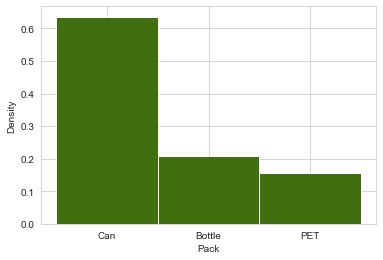

In [14]:
X_and_promo('Pack')

### 3.7 Segment and Promo
1. Not much promo on high margin in test set (half compared training set)
2. More likely to be Promo on MainStream in test set
3. Almost all Promo2 are on Premium

Type of Segment: High Margin
Promo 0 for train: 21828 and Promo 0 for test: 4228
Promo 1 for train: 15453 and Promo 1 for test: 974
Promo 2 for train: 0 and Promo 2 for test: 0

Type of Segment: MainStream
Promo 0 for train: 472000 and Promo 0 for test: 60866
Promo 1 for train: 86484 and Promo 1 for test: 17046
Promo 2 for train: 0 and Promo 2 for test: 16

Type of Segment: Premium
Promo 0 for train: 541745 and Promo 0 for test: 72869
Promo 1 for train: 241286 and Promo 1 for test: 36751
Promo 2 for train: 3525 and Promo 2 for test: 132



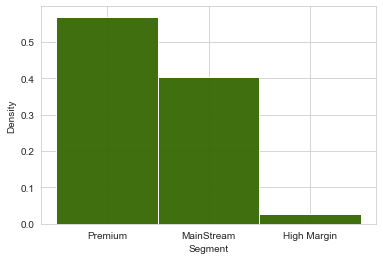

In [15]:
X_and_promo('Segment')

## 3.8 Missing values and inconsistencies

A few remarks:

1. In the dataset, there are 19 products, but only 18 of them are found in the train/test (there is no Holsten)
2. There are no missing values in the original dataset. 

### 3.8.1 Bad Product classification
For example, we see that the 5 last products are missing a proper description of what they are, the type of product is just named "Other". An attempt were made to find out if there were lager, energy drink or non-alcoholic. We found that Baltika Draught and Firmennoe PET are most likely lager. The Don beer seems to be a type of pilsner produced in Southern Russia by Carlsberg. Since it is not a lager, energy drink or non-alcoholic, we will keep it is Other. We found no information about the brand Priazovskoye. 

In [16]:
def lager_fix(train, test):
    for i in range(len(train)):
        if train['SKU'][i] == '_Firmennoe PET 1,42':
            train['Product'][i] = 'lager'
        elif train['SKU'][i] == '_Baltika Draught PET 0,47':
            train['Product'][i] = 'lager'
    for i in range(len(test)):
        if test['SKU'][i] == '_Firmennoe PET 1,42':
            test['Product'][i] = 'lager'
        elif test['SKU'][i] == '_Baltika Draught PET 0,47':
            test['Product'][i] = 'lager'
    return train, test

### 3.8.2 Volume
We see that the volume given in the feature SKU and the volume given in the feature Volume do not match exactly. For example, the Tuborg Green Bottle is described to have a volume of 0.48 in the SKU feature, while 0.50 in the Volume. However, these variations are quite small, so no adjustments were made here.

### 3.8.3 Weird values

We tried replacing "weird values" that was repeated multiple times (e.g., 0.9940000000000001 (this number occured 5383 times, with different promo values and could occur at different stores on the same day). We tried imputating the value based on if it was promo or not, but this didn't give us any better score. Either because our imputation gives a worse "actual value" or perhaps the values are correct (but seems unlikely, at least for the high numbers occuring a few thousand times).

In [17]:
weird_values = [2.982, 0.994, 0.288, 0.144, 0.146, 0.147, 3.692, 5.964, 1.927, 1.846, 1.269, 1.833]

mean_promo = np.mean(train[train['isPromo'] == 1]['Sales'])
mean_promo2 = np.mean(train[train['isPromo'] == 2]['Sales'])
mean_nopromo = np.mean(train[train['isPromo'] == 0]['Sales'])

def fix_values(train):
    for i in weird_values:
        value = train['Sales'] == i
        ispromo = train['isPromo'] == 1
        ispromo2 = train['isPromo'] == 2
        nopromo = train['isPromo'] == 0

        value_index = value[value].index
        ispromo_index = ispromo[ispromo].index
        ispromo2_index = ispromo2[ispromo2].index
        nopromo_index = nopromo[nopromo].index
        weird_valuespromo = list(set(value_index).intersection(ispromo_index))
        weird_valuespromo2 = list(set(value_index).intersection(ispromo2_index))
        weird_valuesnopromo = list(set(value_index).intersection(nopromo_index))
        sum_weird = len(weird_valuespromo) + len(weird_valuespromo2) + len(weird_valuesnopromo)
        print('Number of values for ' + str(i) + ' removed is ', sum_weird)
        for j in weird_valuespromo:
            train['Sales'][j] = mean_promo
        for j in weird_valuespromo2:
            train['Sales'][j] = mean_promo2
        for j in weird_valuesnopromo:
            train['Sales'][j] = mean_nopromo
    return train

## 3.9 Outlier detection

### 3.9.1 Outlier detector: Promo and year

We see that certain ts_id's don't have much promotion. We decided to try running our simulation without 2015, and we got an improvement with this change. First we thought it was because certain ts_id's was missing some of the promo's (they weren't recorded for example, as there was a lot of high sales), but with further analysis we discovered that certain SKU's almost never have promo.  


Store ID: 0


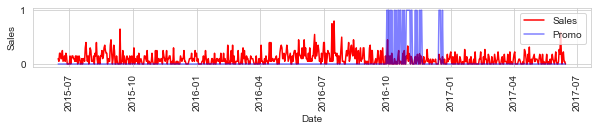

Store ID: 4


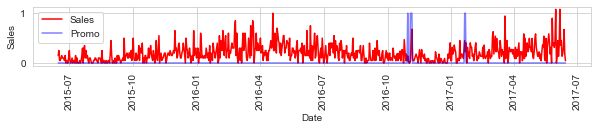

Store ID: 15


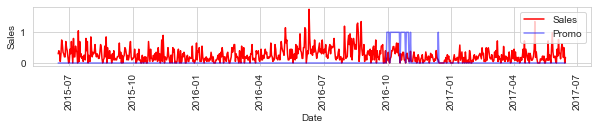

Store ID: 19


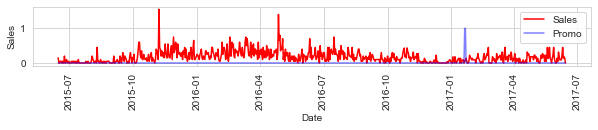

In [18]:
def plot_promo_sales(df, ts_id, j):
    plt.figure(figsize = (10,5))
    plt.subplot(4, 1, j)
    df_ = df[df['ts_id'] == ts_id][['Date', 'isPromo', 'Sales']]
    sns.lineplot(df_['Date'], df_['Sales'], color='r', label = 'Sales')
    sns.lineplot(df_['Date'], df_['isPromo'], color='b', label = 'Promo', alpha = 0.5)
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()
tsid_plot = [0, 4, 15, 19]
j = 1
for i in tsid_plot:
    print('Store ID:', i)
    plot_promo_sales(train, i, j)
    j += 1
def remove2015(train):
    train = train[train['year'] > 2015]
    return train

We explore this further here by looking at how many stores have promo on the SKU at the same time. We see that certain SKUs never have any promo in 2015. 

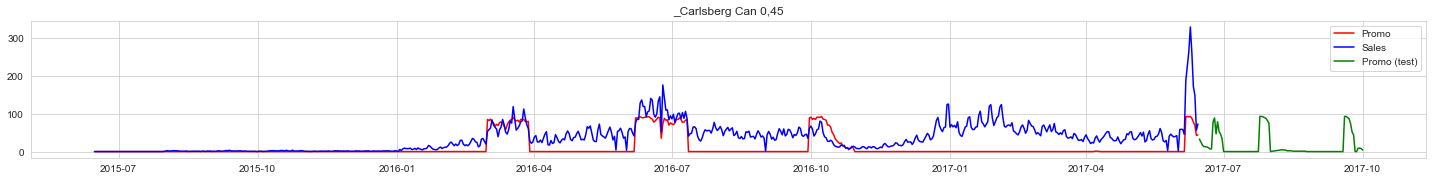

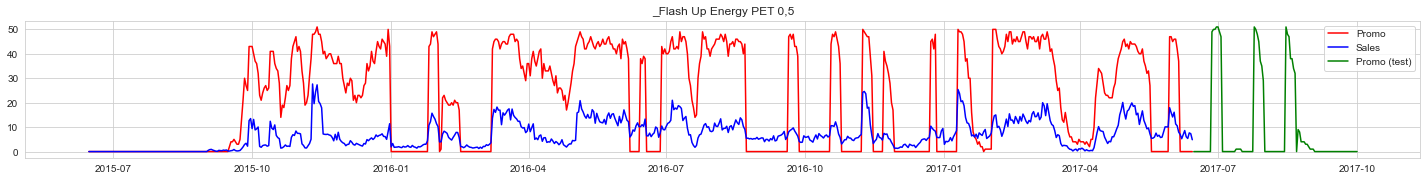

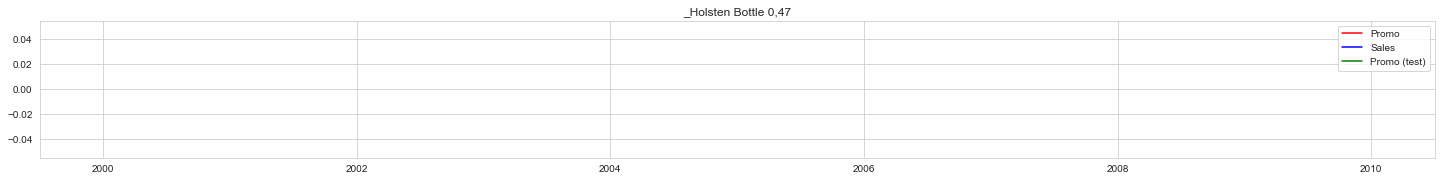

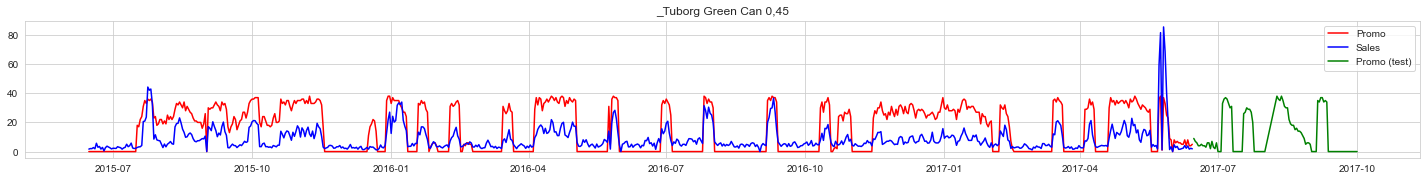

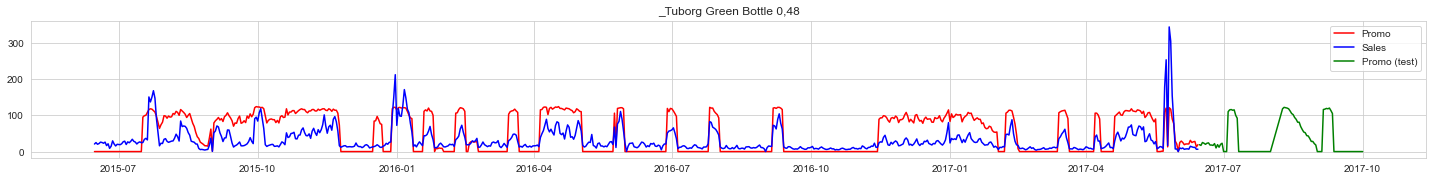

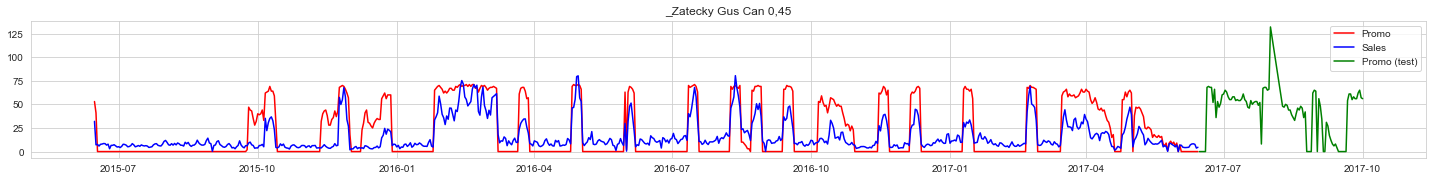

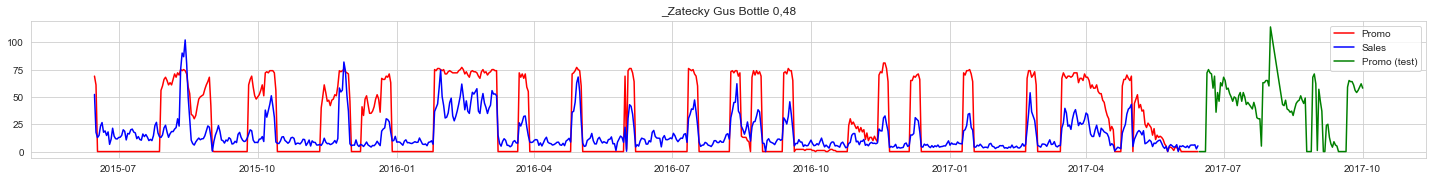

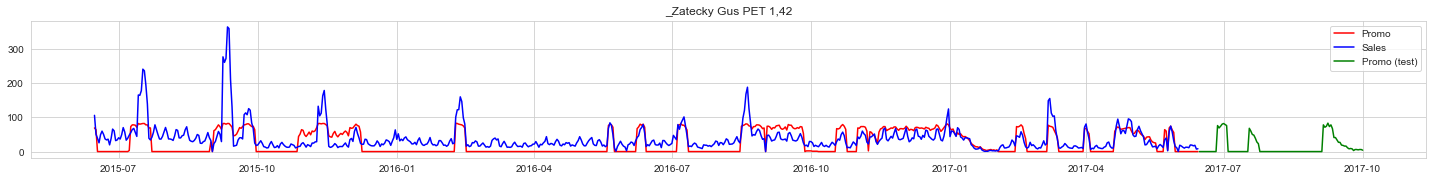

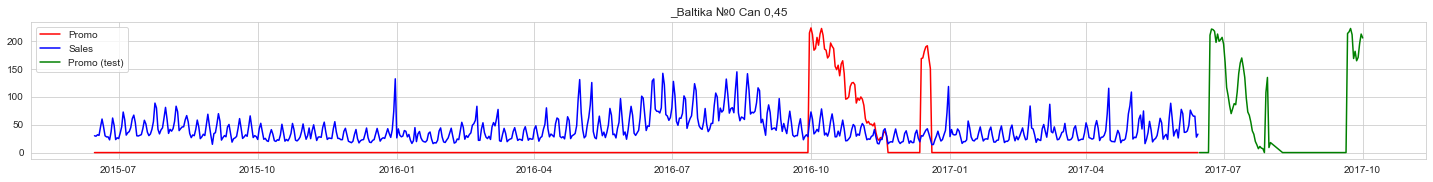

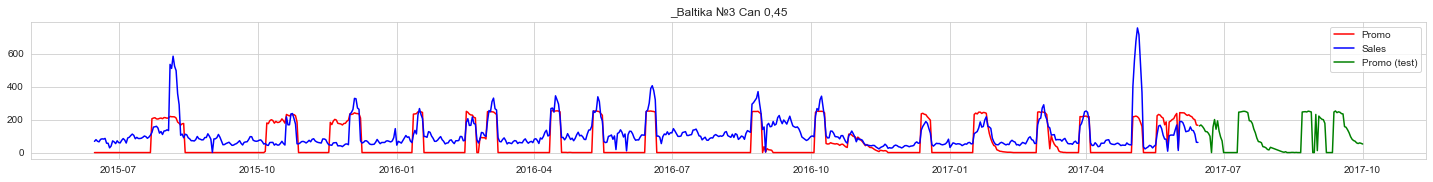

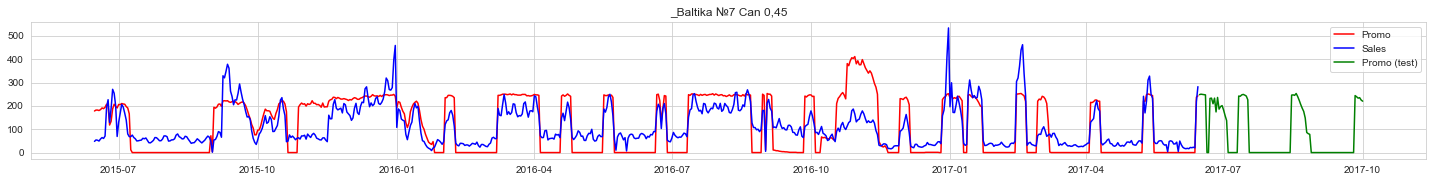

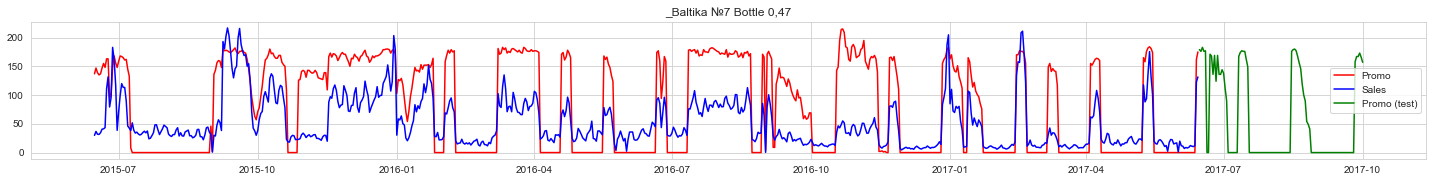

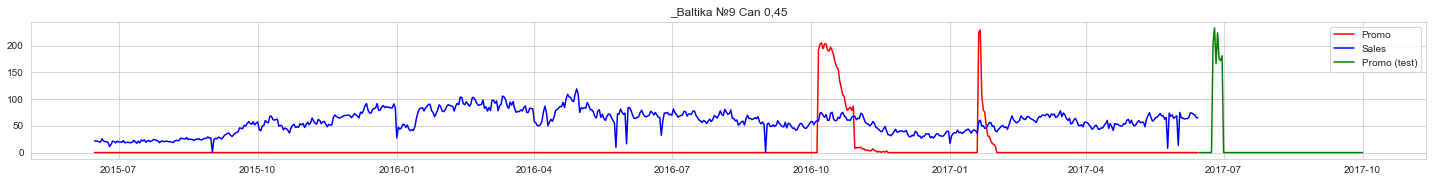

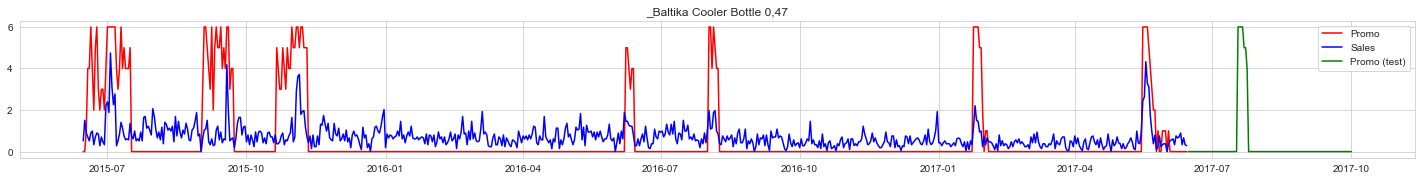

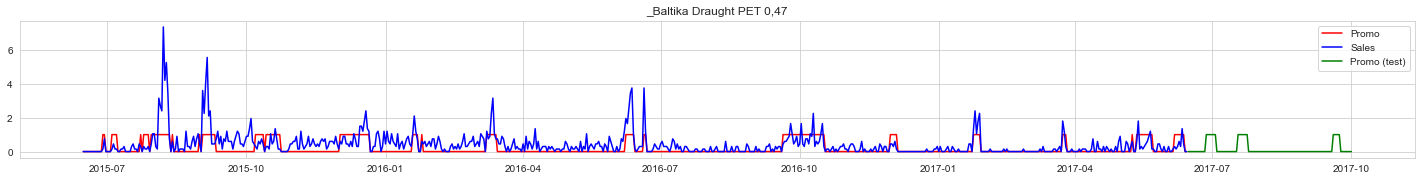

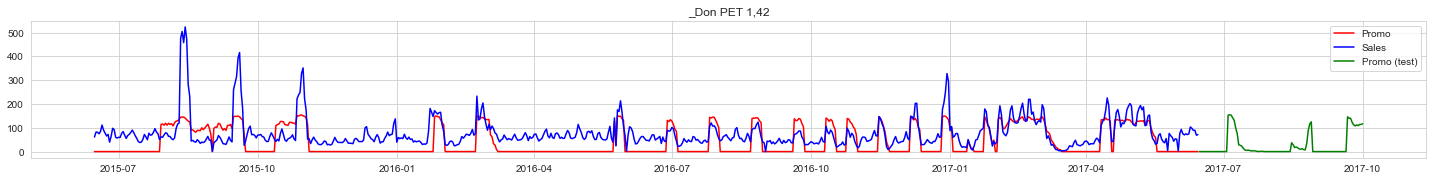

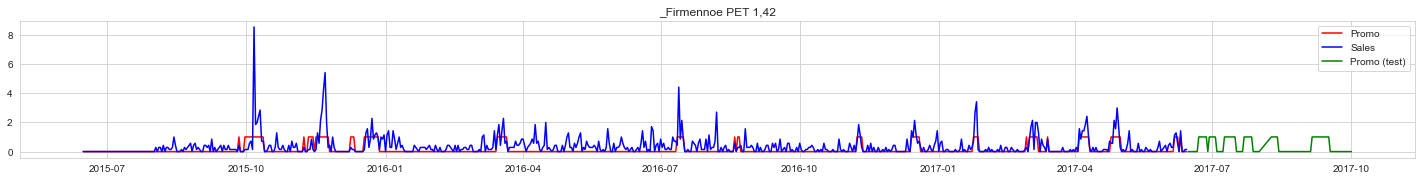

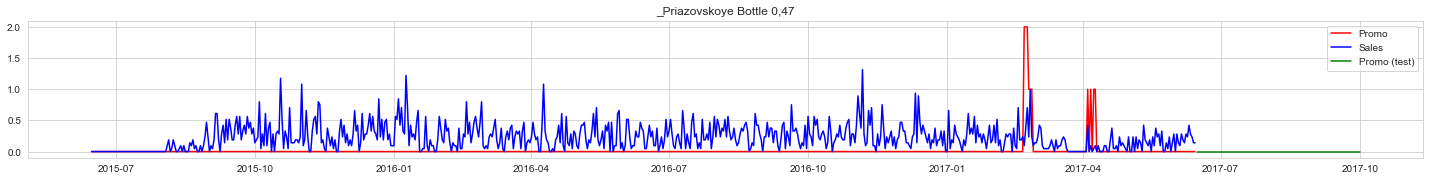

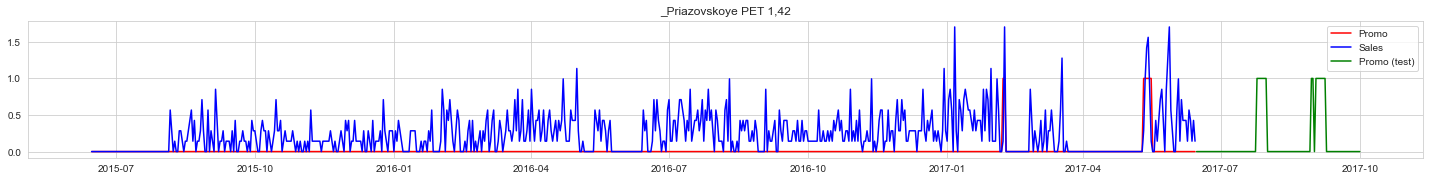

In [19]:
def plot_sku_sales(sku, df, i=1, tot_plots=1, test_promo=None):
    sale_history = df[df.SKU == sku][['Date', 'isPromo', 'Sales']]
    s = sale_history.groupby('Date').agg(['sum']).reset_index()

    plt.figure(figsize = (25,3*tot_plots))
    plt.subplot(tot_plots, 1, i)
    plt.plot(s['Date'], s[('isPromo', 'sum')], color = 'red', label = 'Promo')
    plt.plot(s['Date'], s[('Sales', 'sum')], color = 'blue', label = 'Sales')
    if test_promo is not None:
        t = test_promo[test_promo.SKU == sku][['Date', 'isPromo']].groupby('Date').agg(['sum']).reset_index()
        plt.plot(t['Date'], t[('isPromo', 'sum')], color = 'green', label = 'Promo (test)')
    plt.legend()
    plt.title(str(sku))
    
for i, sku in sku_features.SKU.iteritems():
    plot_sku_sales(sku, train, i + 1, sku_features.SKU.size, test_promo=test)

### 3.9.2. Outlier detector: Large values

If we look at the average sale values for no promo, promo 1 and promo 2, we see that these numbers are below 1, however, there are values that are beyond 10. In addition to large values, there are also a few values that are negative. Either because the wrong number was entered or perhaps some of the products were bad, and had to be turned in again.

We tried removing values above 20, 15 and 10. Removing values above 15 and 20 seems to improve our model, but not when we combined it with also removing all of values in 2015.

In [20]:
print('Average sale if Promo1', mean_promo)
print('Average sale if Promo2', mean_promo2)
print('Average sale if no Promo', mean_nopromo)

def remove_values(train, upper, below):
    print('Remove sales values above ' + str(upper) + ' and below ' + str(below))
    train = train[train['Sales'] < upper]  # remove very large sales values
    train = train[train['Sales'] >= below]  # remove negative large sales values
    return train

Average sale if Promo1 0.680071868727018
Average sale if Promo2 0.6445319148936156
Average sale if no Promo 0.20151279436640848


# 4. Modelling 

## 4.1 Create dataset for the different models

In [21]:
def model1_dataset(model3 = False, model4 = False):
    # Since model1, 3 and 4 are quite similar, we can use a single function to construct the dataset
    train = pd.read_csv('data/beer_train.csv',parse_dates=['Date'])
    test = pd.read_csv('data/beer_test.csv',parse_dates=['Date'])
    sku_features = pd.read_csv('data/sku_features.csv')
    id_map = pd.read_csv('data/id_store_sku.csv')
    
    train, test = create_lag(train, test)
    train = merge(train, sku_features, id_map)
    test = merge(test, sku_features, id_map)
    train = time_features(train)
    test = time_features(test)
    train = promo_features(train)
    test = promo_features(test)
    if model3 or model4:
        train = promo_relation(train)
        test = promo_relation(test)
        
    train = brand_fixer(train)
    test = brand_fixer(test)
    train, test = lager_fix(train, test)
    train = remove2015(train)
    
    if model4:
        remove = ['lag60Promo', 'lag180Promo', 'lag90Promo', 'lag365Promo', 'Brand']
        for i in remove:
            train.pop(i)
            test.pop(i)

    train = train.replace(to_replace='nannan', value=np.nan)
    test = test.replace(to_replace='nannan', value=np.nan)
    return train, test

def model2_dataset():
    train = pd.read_csv('data/beer_train.csv',parse_dates=['Date'])
    test = pd.read_csv('data/beer_test.csv',parse_dates=['Date'])
    sku_features = pd.read_csv('data/sku_features.csv')
    id_map = pd.read_csv('data/id_store_sku.csv')
    
    train, test = create_lag(train, test)
    train = merge(train, sku_features, id_map)
    test = merge(test, sku_features, id_map)
    train = time_features(train)
    test = time_features(test)
    train = promo_features(train)
    test = promo_features(test)

    train = interesting_days(train)
    test = interesting_days(test)
    train = remove_values(train, 15, 0)
    return train, test

def prepare_dataset(train, test):
    train_y = train['Sales']
    del(train['Sales'], train['Date'])
    train_features = train
    del(test['Date'], test['id'])
    test_features = test
    for c in test_features.columns:
        test_features[c] = test_features[c].astype('category')
        train_features[c] = train_features[c].astype('category')
    print('Number of features in train set:', len(train_features.columns))
    print('Number of features in test set:', len(test_features.columns))
    print('Features used in model:', train.columns)
    return train_y, train_features, test_features

### 4.1.1 Four models

For our 3 submissions, we use 4 models. 

In [22]:
train_model1, test_model1 = model1_dataset()
train_y1, train_features1, test_features1 = prepare_dataset(train_model1, test_model1)

train_model2, test_model2 = model2_dataset()
train_y2, train_features2, test_features2 = prepare_dataset(train_model2, test_model2)

# Model3 scores best
train_model3, test_model3 = model1_dataset(model3 = True)
train_y3, train_features3, test_features3 = prepare_dataset(train_model3, test_model3)

# Model4: Here we remove the lag promos and brand (as we got bad feature importance on them with RFE, RFECV, Shap)
train_model4, test_model4 = model1_dataset(model4 = True)
train_y4, train_features4, test_features4 = prepare_dataset(train_model4, test_model4)

Number of features in train set: 29
Number of features in test set: 29
Features used in model: Index(['ts_id', 'isPromo', 'lag_60', 'lag_90', 'lag_180', 'lag_365',
       'lag60Promo', 'lag180Promo', 'lag90Promo', 'lag365Promo', 'Store',
       'SKU', 'Segment', 'Pack', 'Product', 'Brand', 'Volume', 'day_of_month',
       'day_of_week', 'month', 'year', 'week', 'ts_promo', 'store_promo',
       'segment_promo', 'brand_promo', 'sku_promo', 'dom_promo', 'dow_promo'],
      dtype='object')
Remove sales values above 15 and below 0
Number of features in train set: 35
Number of features in test set: 35
Features used in model: Index(['ts_id', 'isPromo', 'lag_60', 'lag_90', 'lag_180', 'lag_365',
       'lag60Promo', 'lag180Promo', 'lag90Promo', 'lag365Promo', 'Store',
       'SKU', 'Segment', 'Pack', 'Product', 'Brand', 'Volume', 'day_of_month',
       'day_of_week', 'month', 'year', 'week', 'ts_promo', 'store_promo',
       'segment_promo', 'brand_promo', 'sku_promo', 'dom_promo', 'dow_promo'

## 4.2 Hyperparameter optimization
To optimize our hyperparameters, there are multiple packages in Python that we can use. We tried Optuna and Hyperopt. They both seem to give good results, but Optuna has some nice visualization tools for the hyperparameters being tuned. 

We started on the house price project. On that project we tried a lot of algorithms, such as decision tree, random forest, neural network, elastic net, XGBoost, LightGBM and CatBoost. We found that XGBoost, LightGBM and CatBoost gave us good results. However, when we switched to the sale forecasting project, the dataset was much larger, and the training time was longer. Out of those 3, LightGBM was clearly the fastest, and thus made hyperparameter tuning much easier. We gave up on XGBoost and Catboost, as they were much slower, which made tuning of parameters "impossible". 

When it comes to LightGBM, there are multiple parameters that can be tuned. Tuning these are not very simple, as there needs to be a balance of making sure that we don't overfit or underfit. A way for the model to generalize better is to use time-series cross-validation. For our parameters, one iteration of Optuna with cross validation took 10-15 minutes, therefore not used. 

To avoid (or reduce) overfitting, we used some of LightGBM tips for reducing overfitting, such as 
- Use small num_leaves (the default is 31, but it seems that most Kaggle competitions try values between $\sim$20-127 (and sometimes even higher), so as far as we can see, we are not using a too large num_leaves)
- Subsample: The default is 1, reducing this can help with overfitting. We tried values in the range 0.5-1.0
- Colsample_bytree: The default is 1, reducing this can help with overfitting. We started with values between 0.1-1.0, but our model always preferred values below 0.30. We therefore swapped the range to 0.1-0.3.
- Regularization (reg_alpha and reg_lambda): The default is 0 for both. We tried in the range [0,100], but found that below 50 was usually the best. We therefore picked the range [0,50].

Since LightGBM is a relatively new algorithm (2016), there isn't too much information about every parameter and they can be very dependent on the dataset. We also tested some categorical parameters in LightGBM, but we couldn't find too much information about these.


To do not get an extremly long notebook, we only run 5 iterations of Optuna, but our best model (Model 3 and also Model 4) was runned using Optuna seed 10 and 80 iterations (so 100% reproducible). Model 1 was runned using 50 iterations (but without Optuna seed). 

As random_state is not something that should be tuned, there we used random_state = 1 for all of our LightGBM simulations.

In [23]:
import optuna
test_ratio = 0.175
def optuna_train(train_features, train_y, train_valid = 'Holdout'):
    if train_valid == 'Holdout':
        X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_features, 
                                                                              train_y, test_size= test_ratio, 
                                                                              random_state = 1, shuffle = False)
    def optunii(trial):
        space = {
            # Parameters for Model 1 and Model 3
            "n_estimators": trial.suggest_int("n_estimators", 1500, 2250),
            "learning_rate": trial.suggest_float("learning_rate", 0.003, 0.005),
            "num_leaves": trial.suggest_int("num_leaves", 20, 127),
            "reg_alpha": trial.suggest_int("reg_alpha", 0, 50),
            "reg_lambda": trial.suggest_int("reg_lambda", 0, 50),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.30),
            "max_cat_threshold": trial.suggest_int('max_cat_threshold', 32, 64),
            'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 120),
            
            # We added these parameters to our Model 3
            'subsample_freq': trial.suggest_categorical('subsample_freq', [1]), # required to make subsample work (default is 0, so the frequency of subsampling is 0)
            'cat_l2': trial.suggest_int('cat_l2', 10, 30), # regularization on categorical features
            'cat_smooth': trial.suggest_int('cat_smooth', 10, 30) # reduces influence on noise in categorical features
        }
        clf = lgbm.LGBMRegressor(**space, random_state = 1)
        if train_valid == 'Holdout':
            clf.fit(X_train, y_train)
            y_valid_hat = clf.predict(X_valid)
            rmse = rmse_loss(y_true = y_valid, y_pred = y_valid_hat)
        elif train_valid == 'CVSplit':
            nfold = 7
            folds = TimeSeriesSplit(n_splits = nfold)

            splits = folds.split(train_features, train_y)
            scores = []

            for fold_n, (train_index, valid_index) in enumerate(splits):
                X_train_split, X_valid_split = train_features.iloc[train_index], train_features.iloc[valid_index]
                y_train_split, y_valid_split = train_y.iloc[train_index], train_y.iloc[valid_index]

                clf.fit(X_train_split, y_train_split,verbose = -1)
                y_pred = clf.predict(X_valid_split)

                scores.append(rmse_loss(y_true = y_valid_split, y_pred = y_pred))
                del X_train_split, X_valid_split, y_train_split, y_valid_split

        return rmse
    sampler = TPESampler(seed = 10)  
    study = optuna.create_study(direction="minimize", study_name="LGBM1", sampler = sampler)
    func = lambda trial: optunii(trial)
    study.optimize(func, n_trials= 5)
    lgb_param = study.best_params
    return lgb_param

In [24]:
def Train_model(method, space, Xt, yt, Xv, yv, type_split = 'Holdout', max_trials = 50):
    def objective(space):
        if method == 'XGB':
            clf = xgboost.XGBRegressor(**space, random_state = 1)
        elif method == 'Cat':
            clf = CatBoostRegressor(**space, random_state = 1, verbose = False)
        else:
            clf = lgbm.LGBMRegressor(**space, random_state = 1)
        clf.fit(Xt, yt)
        y_valid_hat = clf.predict(Xv)
        rmse = rmse_loss(y_true = yv, y_pred = y_valid_hat)
        return{'loss': rmse, 'status': STATUS_OK}
    rstate = np.random.RandomState(1)
    trials = Trials()
    max_evals = max_trials
    with trange(max_evals) as t:
        for e in t:
            best = fmin(fn=objective, space=space, 
                        algo = tpe.suggest,
                        rstate = rstate,
                        max_evals=e+1, trials=trials, show_progressbar=False, 
                        verbose = True)
            t.set_postfix(K=space_eval(space,best), best_loss=min(trials.losses()))
    return space_eval(space, best)

## 4.3 LightGBM

### 4.3.1 LightGBM: Model 1, Model 3 and 4

For model 1, we use Optuna to find "optimal" parameters. When we found good parameters, we train on the whole dataset, then perform feature importance using both split and gain.

[I 2021-11-19 06:33:42,867] A new study created in memory with name: LGBM1
[I 2021-11-19 06:35:59,225] Trial 0 finished with value: 0.4803271855523523 and parameters: {'n_estimators': 2079, 'learning_rate': 0.003041503898718803, 'num_leaves': 88, 'reg_alpha': 38, 'reg_lambda': 25, 'subsample': 0.6123983227654238, 'colsample_bytree': 0.1396125729519248, 'max_cat_threshold': 57, 'min_data_per_group': 62, 'subsample_freq': 1, 'cat_l2': 11, 'cat_smooth': 24}. Best is trial 0 with value: 0.4803271855523523.
[I 2021-11-19 06:38:15,269] Trial 1 finished with value: 0.4810053021867721 and parameters: {'n_estimators': 2215, 'learning_rate': 0.003007896532655829, 'num_leaves': 75, 'reg_alpha': 41, 'reg_lambda': 31, 'subsample': 0.8608776587158997, 'colsample_bytree': 0.15837521363412663, 'max_cat_threshold': 62, 'min_data_per_group': 100, 'subsample_freq': 1, 'cat_l2': 21, 'cat_smooth': 12}. Best is trial 0 with value: 0.4803271855523523.
[I 2021-11-19 06:40:14,621] Trial 2 finished with value: 

{'n_estimators': 1764, 'learning_rate': 0.004509295383059714, 'num_leaves': 51, 'reg_alpha': 45, 'reg_lambda': 16, 'subsample': 0.5825079488595742, 'colsample_bytree': 0.17850584878931747, 'max_cat_threshold': 35, 'min_data_per_group': 108, 'subsample_freq': 1, 'cat_l2': 13, 'cat_smooth': 18}


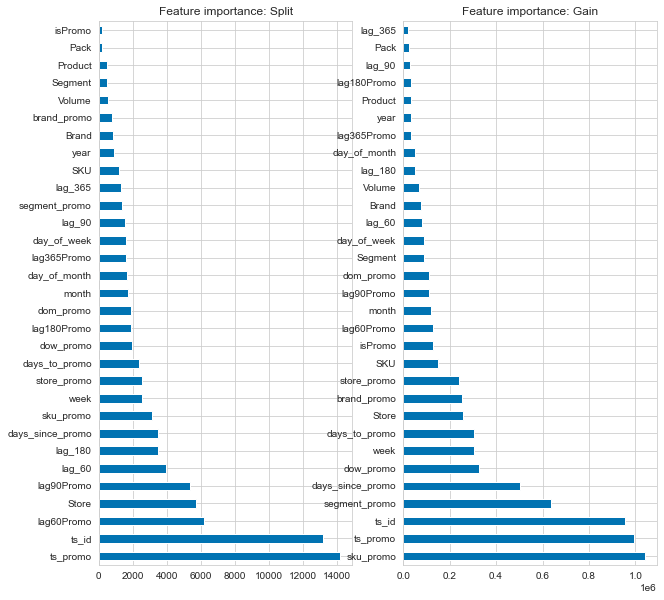

In [25]:
lgb_param = optuna_train(train_features3, train_y3, train_valid = 'Holdout')
print(lgb_param)

model_lgbm = lgbm.LGBMRegressor(**lgb_param, random_state = 1)
model_lgbm.fit(train_features3, train_y3)

# Plotting feature importance
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('Feature importance: Split')
feat_imp = pd.Series(model_lgbm.feature_importances_, index=train_features3.columns)
feat_imp.nlargest(45).plot(kind='barh', figsize=(10,10))
plt.subplot(1,2,2)
plt.title('Feature importance: Gain')
feat_imp = pd.Series(model_lgbm.booster_.feature_importance(importance_type='gain'), index=train_features3.columns)
feat_imp.nlargest(45).plot(kind='barh', figsize=(10,10))
plt.show()

### 4.3.2 LightGBM: Model 2

100%|██████████| 5/5 [09:51<00:00, 118.38s/it, K={'colsample_bytree': 0.16202646298238624, 'learning_rate': 0.0035499854786659427, 'max_depth': 8, 'n_estimators': 1787, 'num_leaves': 51, 'reg_alpha': 38.49339446151476, 'reg_lambda': 0.6724525254565072, 'subsample': 0.8491197036621863}, best_loss=0.455]


{'colsample_bytree': 0.16202646298238624, 'learning_rate': 0.0035499854786659427, 'max_depth': 8, 'n_estimators': 1787, 'num_leaves': 51, 'reg_alpha': 38.49339446151476, 'reg_lambda': 0.6724525254565072, 'subsample': 0.8491197036621863}


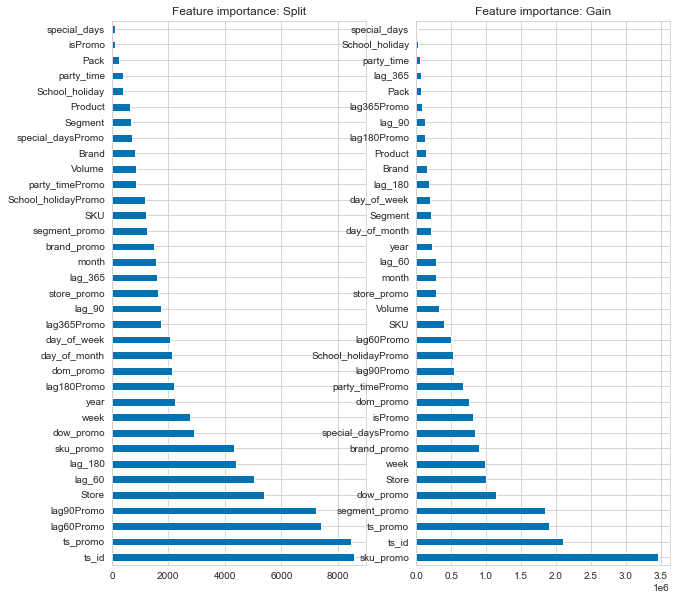

In [26]:
space = { 
    'n_estimators': hp.choice('n_estimators', range(1500, 2251)),
    'learning_rate': hp.uniform('learning_rate',0.003, 0.005),
    'max_depth': hp.choice('max_depth', [7, 8]),
    'num_leaves': hp.choice('num_leaves', range(5, 127)),
    'subsample': hp.uniform('subsample', 0.6, 0.9), # also known as bagging_fraction
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.3), # also known as feature fraction
    'reg_alpha': hp.uniform('reg_alpha', 0, 50),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 50),
}
X_train_model2, X_valid_model2, y_train_model2, y_valid_model2 = model_selection.train_test_split(train_features2, train_y2, test_size= test_ratio, 
                                                                                                   random_state = 1, shuffle = False)
lgb_param_hyperopt = Train_model('LGBM', space, X_train_model2, y_train_model2, 
                        X_valid_model2, y_valid_model2, type_split = 'Holdout', max_trials = 5)
print(lgb_param_hyperopt)
model_lgbm2 = lgbm.LGBMRegressor(**lgb_param_hyperopt, random_state = 1)
model_lgbm2.fit(train_features2, train_y2)
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('Feature importance: Split')
feat_imp = pd.Series(model_lgbm2.feature_importances_, index=train_features2.columns)
feat_imp.nlargest(45).plot(kind='barh', figsize=(10,10))
plt.subplot(1,2,2)
plt.title('Feature importance: Gain')
feat_imp = pd.Series(model_lgbm2.booster_.feature_importance(importance_type='gain'), index=train_features2.columns)
feat_imp.nlargest(45).plot(kind='barh', figsize=(10,10))
plt.show()

## 4.4 Submissions

### 4.4.1 Model 3
Our best submission on the Kaggle leaderboard uses Model 3.


**NB: Since we can only use 2 submissions now, we decided to drop this**

In [29]:
# Our best score is by using the features/data-cleaning found in model1_dataset(model3 = True)
# with the following parameters for LGBM 
submission1 = pd.read_csv('data/intro_submission.csv')
lgb_param_model3 = {'n_estimators': 1915, 'learning_rate': 0.0049319743191803544, 'num_leaves': 116, 
                    'reg_alpha': 34, 'reg_lambda': 49, 'subsample': 0.9872621712765213, 'subsample_freq': 1, 
                    'colsample_bytree': 0.11944549125971712, 'max_cat_threshold': 60, 'min_data_per_group': 93, 
                    'cat_l2': 22, 'cat_smooth': 12}

submission3 = pd.read_csv('data/intro_submission.csv')
model_lgbm3 = lgbm.LGBMRegressor(**lgb_param_model3, random_state = 1)
model_lgbm3.fit(train_features3, train_y3)
prediction_model3 = model_lgbm3.predict(test_features3)

submission1['Sales'] = prediction_model3
submission1.to_csv('Submission1.csv', index=False)

### 4.4.2 Model1 + Model2
Our 2nd submission is Model1 + Model2. We give Model1 more weight, as it scores better. This submission is called FinalSubmission2 on Kaggle

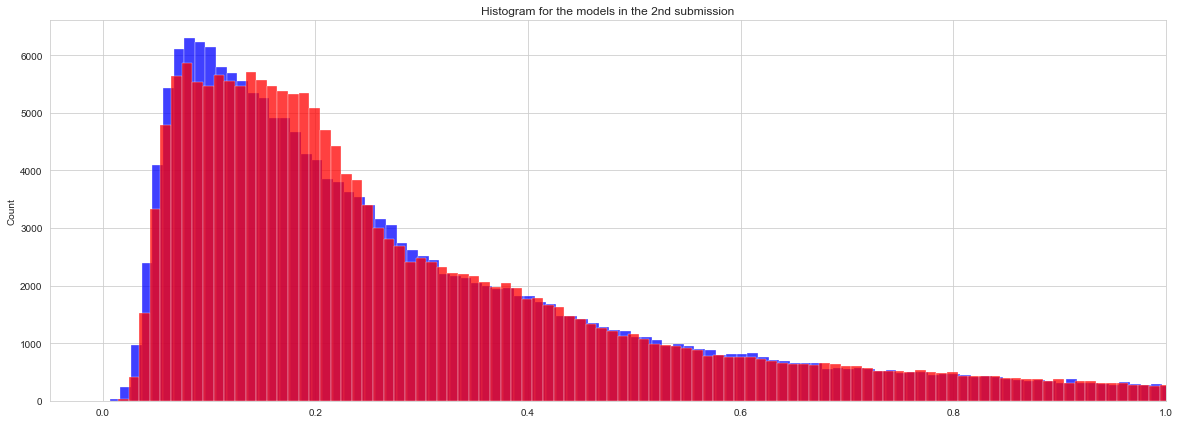

In [33]:
submission2 = pd.read_csv('data/intro_submission.csv')

lgb_param_model1 = {'n_estimators': 1566, 'learning_rate': 0.004370719636735594, 'num_leaves': 122,  
             'reg_alpha': 0, 'reg_lambda': 26, 'subsample': 0.9063104808260567, 'cat_l2': 17, 'cat_smooth': 10,
             'colsample_bytree': 0.22250521336587764, 'max_cat_threshold': 55, 'min_data_per_group': 70}

model_lgbm1 = lgbm.LGBMRegressor(**lgb_param_model1, random_state = 1)
model_lgbm1.fit(train_features1, train_y1)
prediction_model1 = model_lgbm1.predict(test_features1)

lgb_param_model2 = {'colsample_bytree': 0.1595013602757808, 'learning_rate': 0.004230626203615872, 'max_depth': 8, 
             'n_estimators': 1833, 'num_leaves': 118, 'reg_alpha': 15.418374764903756, 
             'reg_lambda': 32.11982305383127, 'subsample': 0.8928231814360663}

model_lgbm2 = lgbm.LGBMRegressor(**lgb_param_model2, random_state = 1)
model_lgbm2.fit(train_features2, train_y2)
prediction_model2 = model_lgbm2.predict(test_features2)

# A Model1 scores better than Model2, we give it more weight
submission2['Sales'] = 0.65*prediction_model1 + 0.35*prediction_model2
submission2.to_csv('Submission2.csv', index=False)

plt.figure(figsize = (20,7))
plt.title('Histogram for the models in the 2nd submission')
sns.histplot(prediction_model1, color = 'blue', binwidth = 0.01)
sns.histplot(prediction_model2, color = 'red', binwidth = 0.01)
plt.xlim([-0.05,1.0])
plt.show()


### 4.4.3 Model3 + Model4
Our 3rd submission is Model3 + Model4. We give Model3 more weight, as it scores better.

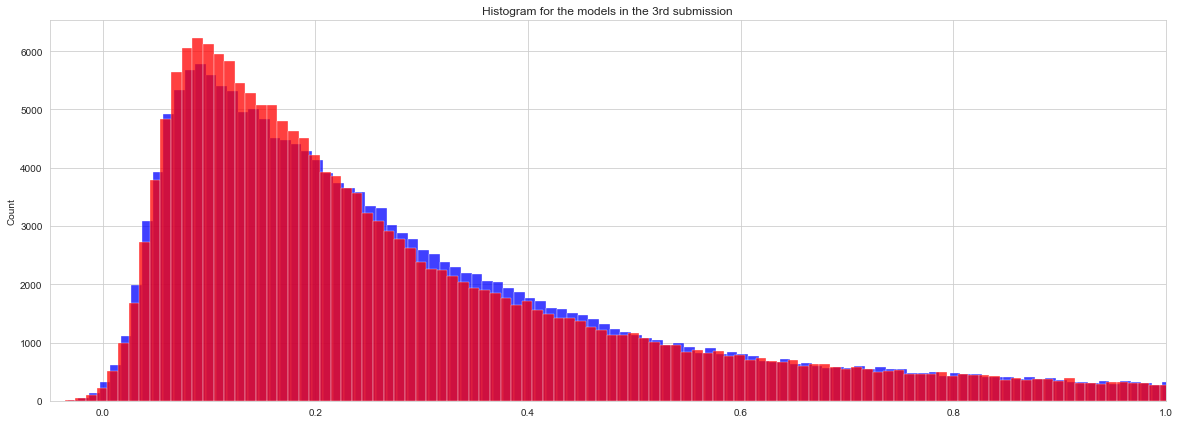

In [34]:
# Our 3rd submission combines the model 3 with model 4
# They seem to have quite a different distribution, as observed below
submission3 = pd.read_csv('data/intro_submission.csv')
lgb_param_model4 = {'n_estimators': 2156, 'learning_rate': 0.004954170518408145, 'num_leaves': 108, 
             'reg_alpha': 40, 'reg_lambda': 21, 'subsample': 0.9261717756336443, 'subsample_freq': 1, 
             'colsample_bytree': 0.16903417694268677, 'max_cat_threshold': 63, 'min_data_per_group': 55, 'cat_l2': 23, 'cat_smooth': 15}
model_lgbm1 = lgbm.LGBMRegressor(**lgb_param_model4, random_state = 1)
model_lgbm1.fit(train_features4, train_y4)
prediction_model4 = model_lgbm1.predict(test_features4)

# Since model3 scores better, we put some more weight on it
submission3['Sales'] = 0.60*prediction_model3 + 0.40*prediction_model4
submission3.to_csv('Submission3.csv', index=False)

plt.figure(figsize = (20,7))
plt.title('Histogram for the models in the 3rd submission')
sns.histplot(prediction_model4, color = 'blue', binwidth = 0.01)
sns.histplot(prediction_model3, color = 'red', binwidth = 0.01)
plt.xlim([-0.05,1.0])
plt.show()

## 4.5 Ordinal encoding
Since XGBoost does not handle categorical features (only experimental support, which is not recommended by their creators), we need to turn the categorical features into numerical features. To do this, we choose to use ordinal encoder (**Note**: since our data contains NaN values (due to the lag features) and Sklearn's ordinal encoder only started supporting this in Scikit version 1.0 or higher, we must make sure that we have the correct version). 

In [35]:
train_features_xgb = train_features3
test_features_xgb = test_features3

category1 = ['Store','lag60Promo', 'lag180Promo', 'lag90Promo', 'lag365Promo',
       'SKU', 'Segment', 'Pack', 'Product', 'Brand','ts_promo', 'store_promo',
       'segment_promo', 'brand_promo', 'sku_promo','dom_promo', 'dow_promo',]

category = category1

float_var = ['Volume', 'day_of_month', 'day_of_week', 'ts_id', 'isPromo', 'days_since_promo', 'days_to_promo']
for f in float_var:
    test_features_xgb[f] = test_features_xgb[f].astype('float')
    train_features_xgb[f] = train_features_xgb[f].astype('float')

for c in category:
    test_features_xgb[c] = test_features_xgb[c].astype('category')
    train_features_xgb[c] = train_features_xgb[c].astype('category')

train_features_xgb['train'] = 1
test_features_xgb['train'] = 0
combined2 = pd.concat([train_features_xgb,test_features_xgb])

from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
combined2[category] = enc.fit_transform(combined2[category])

combined2 = pd.DataFrame(combined2, columns = test_features_xgb.columns)

train_features_xgb = combined2[combined2['train'] == 1]
test_features_xgb = combined2[combined2['train'] == 0]
train_features_xgb.drop(['train'], axis = 1, inplace = True)
test_features_xgb.drop(['train'], axis = 1, inplace = True)

In [36]:
X_train_xgb, X_valid_xgb, y_train_xgb, y_valid_xgb = model_selection.train_test_split(train_features_xgb, train_y3, test_size= test_ratio, 
                                                                      random_state = 1, shuffle = False)

## 4.6 Feature analysis 

Since we now have transformed our categorical features into numerical, we can use some of Sklearn's feature analysis tools. 

In [37]:
# Since RFE, RFECV and PDP takes quite some time, we used a pretty basic model. 
# It would be interesting to compare the feature analysis on our basic model with our best model, but that was never attempted
estimator = lgbm.LGBMRegressor(random_state = 1)

### 4.6.1: RFE
RFE works by removing the worst feature, and continue to do it until it reaches the selected number of features. An issue with RFE is that we have to choose the number of important features, which we don't know. By selecting 20 features, we get that the 6 worst features are the lag promos, segment_promo and brand. 

RFE uses the models feature importance do determine which features are good/bad. RFE also tries to eliminate any dependency and collinearity that may exist between the features. 

In [41]:
feature_select = 20
print('Number of important features to select', feature_select)
selector = RFE(estimator, step = 1, n_features_to_select = feature_select)
selector = selector.fit(train_features_xgb, train_y1)

for i in range(len(selector.ranking_)):
    if selector.ranking_[i] > 1:
        print(selector.ranking_[i], train_features_xgb.columns[i])

Number of important features to select 20
10 lag60Promo
11 lag180Promo
9 lag90Promo
7 lag365Promo
2 Pack
5 Product
12 Brand
3 store_promo
8 segment_promo
4 sku_promo
6 dow_promo


### 4.6.2 RFECV

RFECV uses cross-validation to determine which features are good for the model. Since we are dealing a time-series, cross-validation is not a good idea. Instead we use time-series splitting with 10 folds. A good thing about RFECV is that we don't have to choose how many features we want in our model. 

We see here that the 5 worst features using RFE is also the 5 worst features using RFECV. 

In [42]:
nfold = 10
folds = TimeSeriesSplit(n_splits = nfold)

selector = RFECV(estimator, step=1, cv=folds)
selector = selector.fit(train_features_xgb, train_y1)

for i in range(len(selector.ranking_)):
    if selector.ranking_[i] > 1:
        print(selector.ranking_[i], train_features_xgb.columns[i])

5 lag60Promo
6 lag180Promo
4 lag90Promo
2 lag365Promo
7 Brand
3 segment_promo


### 4.6.3: Partial dependence plot

The PDP gave us a lot of interesting information. We display those we found the most interesting/informative. 

1. We see that the sale numbers increases with by the end of the month. This may have to do with people getting salary in the middle of the month. 

2. As we noted before, we also see that the sale numbers are higher of friday and saturday, and quite flat for monday-thursday. 

3. If we look at the PDP plot of week, we notice a sudden jump in februrar, then grows slowly up until summer start (then becomes quite flat), then drops down heavily, then goes back up around christmas. Something interesting we saw with the brand Baltik N0 was that it had almost no promos, but it seems to be on sale when the sale is lowest (by week). 

4. We see that certain SKU's are more popular compared to other.
5. There is little variation in Brand

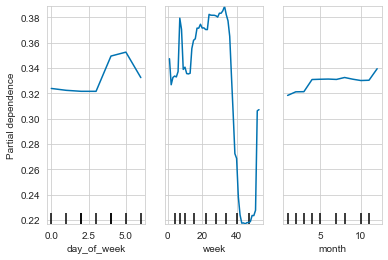

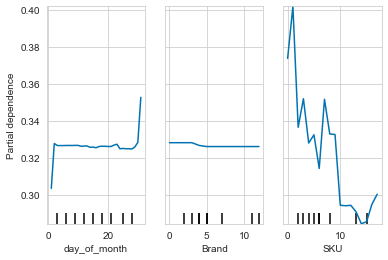

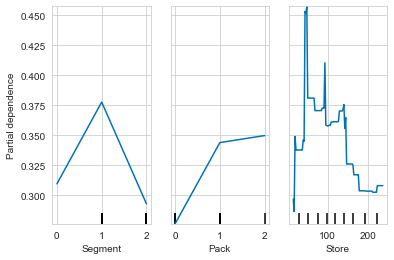

In [69]:
clf = estimator.fit(X_train_xgb, y_train_xgb)
features = [18, 21, 19]
PartialDependenceDisplay.from_estimator(clf, X_train_xgb, features)
features = [17, 15, 11]
PartialDependenceDisplay.from_estimator(clf, X_train_xgb, features)
features = [12, 13, 10]
PartialDependenceDisplay.from_estimator(clf, X_train_xgb, features)

### 4.6.4 SHAP feature importance

We see that the SHAP gives us pretty similar result as we observed using RFE/RFECV. We see that Brand and the different lagPromo features (except lag60Promo) are the one that score the worst. We observe that they do have some feature importance, but not much. Removing them gave a slightly worse result.

<a href="https://imgbb.com/"><img src="https://i.ibb.co/Y3j5Hcq/shap.png" alt="shap" border="0" /></a>



Due to do some issues with having the correct version of packages, we could not get the shap feature importance to run on our computer, but it worked fine on the Kaggle. We therefore post an image.

In [44]:
# clf = estimator.fit(X_train_xgb, y_train_xgb)
# explainer = shap.TreeExplainer(clf, iteration_range = num_estimators)
# shap_values = explainer.shap_values(X_train_xgb)
# shap.summary_plot(shap_values, X_train_xgb, plot_type="bar", max_display = X_train_xgb.shape[1])

### 4.6.5 Other attempts

We also wanted to try to use Sklearn's SelectKBest with mutual regression and LocalOutierFactor, but these were not possible to use as our dataset contains nan values due to the lag features.

In [45]:
# Does not work with nan values
#from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel
# chi_selector = SelectKBest(mutual_info_regression, k= 20)
# chi_selector.fit(X_train_xgb, y_train_xgb)

# chi_support = chi_selector.get_support()
# for i in range(len(features)):
#     print(chi_support[i], features[i])

# from sklearn.neighbors import LocalOutlierFactor
# print(X_train_xgb.shape)
# X_train_xgb = np.array(X_train_xgb)
# yhat = LocalOutlierFactor().fit_predict(X_train_xgb)
# mask = yhat != -1
# X_train_xgb, y_train_xgb = X_train_xgb[mask, :], y_train_xgb[mask]
# X_train_xgb = pd.DataFrame(data = X_train_xgb, columns = X_train.columns)
# print(X_train_xgb.shape)

## 4.7 XGBoost

We tried running XGBoost on the dataset, but due to the time it took, we didn't try much. These are the parameters that we had good luck with on the house price project. We only ran 1 iteration (to show that it works) below as it takes 20 min for a single iteration.

In [46]:
xgb_space = {
    'n_estimators' : hp.choice('n_estimators', range(1000,2001)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.05),
    'max_depth': hp.choice("max_depth", range(7,16)),
    'min_child_weight': hp.uniform('min_child_weight ', 0, 10),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
    'reg_alpha' : hp.uniform('reg_alpha', 0, 50),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 50),
    }
X_train_model2, X_valid_model2, y_train_model2, y_valid_model2 = model_selection.train_test_split(train_features_xgb, train_y3, test_size= test_ratio, 
                                                                                                   random_state = 1, shuffle = False)


In [49]:
xgb_param_hyperopt = Train_model('XGB', xgb_space, X_train_model2, y_train_model2, 
                        X_valid_model2, y_valid_model2, type_split = 'Holdout', max_trials = 1)

100%|██████████| 1/1 [17:59<00:00, 1079.48s/it, K={'colsample_bytree': 0.8076371840473894, 'learning_rate': 0.01362280797062875, 'max_depth': 8, 'min_child_weight': 6.699774084852881, 'n_estimators': 1249, 'reg_alpha': 47.45967098842719, 'reg_lambda': 33.85572357943156, 'subsample': 0.315595564665503}, best_loss=0.492]


## 4.8 CatBoost

Similar to XGBoost, CatBoost also took a long time. Therefore we only run 1 iteration of Hyperopt to show that it works.

In [50]:
cat_space = {
    'n_estimators': hp.choice('n_estimators', range(2500, 3000)),
    'learning_rate': hp.uniform('learning_rate',0.1, 0.3),
    'max_depth': hp.choice('max_depth', range(5,10)),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 10),
}

cat_param_hyperopt = Train_model('Cat', cat_space, X_train_model2, y_train_model2, 
                        X_valid_model2, y_valid_model2, type_split = 'Holdout', max_trials = 1)

100%|██████████| 1/1 [07:47<00:00, 467.33s/it, K={'bagging_temperature': 0.5782233008102186, 'colsample_bylevel': 0.6916055965050213, 'l2_leaf_reg': 9.491934197685438, 'learning_rate': 0.23542289431772626, 'max_depth': 9, 'n_estimators': 2632}, best_loss=0.497]


## 4.9 Other models

We didn't try too many models. One reason is that we started a bit late (as we initially started on the house price project, but at some point stopped getting improved results, but managed to get much quicker good results on the Sale forecasting project due to our good insight to parameter tuning from the other project).

Some interesting models to try would be time-series releated model (such as ARIMA or SARIMAX). It could also be interested to try stacking different models.